# Active Learning Experiments

In [26]:
import matplotlib.pyplot as plt

#plt.style.use('seaborn-v0_8-pastel')
plt.style.use('bmh')
SMALL_SIZE = 12
MEDIUM_SIZE = 14
BIGGER_SIZE = 16
# plt.rcParams['axes.facecolor'] = 'white'
# plt.rcParams['figure.facecolor'] = 'white'

plt.rcParams['lines.linewidth'] = 2
plt.rcParams["font.family"] = "serif"
plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title


## Approximation Expectation

In [6]:
import mlflow
import numpy as np
import pylab as plt
import pandas as pd

# client = mlflow.tracking.MlflowClient(tracking_uri='sqlite:////home/dhuseljic/mlflow/bait/cifar10_ablation_expectation.db')
client = mlflow.tracking.MlflowClient(tracking_uri='sqlite:////home/dhuseljic/mlflow/bait/letter_ablation_expectation.db')
experiment_id = client.get_experiment_by_name('Active Learning').experiment_id

# Food-101
# client = mlflow.tracking.MlflowClient(tracking_uri='file:///home/dhuseljic/mlflow/ssal/al/food101')
# experiment_id = '270441571896962032'
runs = client.search_runs(experiment_ids=experiment_id)
print('Found {} experiments'.format(len(runs)))

Found 50 experiments


In [7]:
runs = []
init_query_list = [
    # "parameter.model.name = 'laplace_mlp'",
    "parameter.dino_model_name = 'dinov2_vits14'",
]
query_list = init_query_list + ["parameter.al.strategy = 'random'"]
query = ' and '.join(query_list)
runs.extend(client.search_runs(experiment_ids=experiment_id, filter_string=query))

query_list = init_query_list + ["parameter.al.strategy = 'typiclust'"]
query = ' and '.join(query_list)
runs.extend(client.search_runs(experiment_ids=experiment_id, filter_string=query))

query_list = init_query_list + ["parameter.al.strategy = 'bait'"]
query_list += ["parameter.al.bait.fisher_approximation = 'full'"] 
query_list += ["parameter.al.bait.expectation_topk = 'None'"] 
query_list += ["parameter.al.bait.num_grad_samples = 'None'"] 
query_list += ["parameter.al.bait.grad_likelihood = 'cross_entropy'"] 
query = ' and '.join(query_list)
runs_ = client.search_runs(experiment_ids=experiment_id, filter_string=query)
for r in runs_:
    r.data.params['al.strategy'] = 'full_' + r.data.params['al.strategy']
runs.extend(runs_)

for i in range(11):
    query_list = init_query_list + ["parameter.al.strategy = 'bait'"]
    query_list += ["parameter.al.bait.fisher_approximation = 'full'"] 
    query_list += [f"parameter.al.bait.expectation_topk = '{i}'"] 
    query_list += ["parameter.al.bait.num_grad_samples = 'None'"] 
    query_list += ["parameter.al.bait.grad_likelihood = 'cross_entropy'"] 
    query = ' and '.join(query_list)
    runs_ = client.search_runs(experiment_ids=experiment_id, filter_string=query)
    for r in runs_:
        r.data.params['al.strategy'] = f'{r.data.params["al.bait.expectation_topk"]}' + '_ours'
    runs.extend(runs_)

query_list = init_query_list + ["parameter.al.strategy = 'bait'"]
query_list += ["parameter.al.bait.fisher_approximation = 'full'"] 
query_list += ["parameter.al.bait.expectation_topk = '1'"] 
query_list += ["parameter.al.bait.num_grad_samples = 'None'"] 
query_list += ["parameter.al.bait.grad_likelihood = 'cross_entropy_unbiased'"] 
query = ' and '.join(query_list)
runs_ = client.search_runs(experiment_ids=experiment_id, filter_string=query)
for r in runs_:
    r.data.params['al.strategy'] = f'{r.data.params["al.bait.expectation_topk"]}' + '_unbiased'
runs.extend(runs_)

# query_list = init_query_list + ["parameter.al.strategy = 'bait'"]
# query_list += ["parameter.al.bait.fisher_approximation = 'full'"] 
# query_list += ["parameter.al.bait.expectation_topk = '1'"] 
# query_list += ["parameter.al.bait.num_grad_samples = 'None'"] 
# query_list += ["parameter.al.bait.grad_likelihood = 'cross_entropy'"] 
# query = ' and '.join(query_list)
# runs_ = client.search_runs(experiment_ids=experiment_id, filter_string=query)
# for r in runs_:
#     r.data.params['al.strategy'] = f'{r.data.params["al.bait.expectation_topk"]}' + r.data.params['al.strategy']
# runs.extend(runs_)

print('Found {} experiments'.format(len(runs)))

Found 50 experiments


In [8]:
al_strats = np.unique([run.data.params['al.strategy'] for run in runs])

learning_curves = {k: [] for k in al_strats}
query_times = {k: [] for k in al_strats}
num_samples = {k: [] for k in al_strats}

for run in runs:
    al_strat = run.data.params['al.strategy']
    # if "al.update_every" in run.data.params: continue
    acc_history = client.get_metric_history(run.info.run_id, 'accuracy')
    learning_curves[al_strat].append([metric.value for metric in acc_history])

    qtime_history = client.get_metric_history(run.info.run_id, 'query_time')
    query_times[al_strat].append([metric.value for metric in qtime_history][1:])

    num_init = int(run.data.params['al.num_init_samples'])
    num_acq = int(run.data.params['al.num_acq'])
    acq_size = int(run.data.params['al.acq_size'])
    num_samples[al_strat].append(range(num_init, num_init+num_acq*acq_size+1, acq_size))

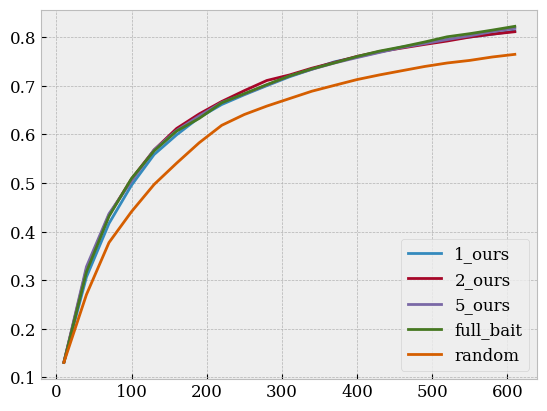

In [9]:
for al_strat in al_strats:
    lcs = learning_curves[al_strat]
    lcs = [lc for lc in lcs if len(lc) > 20]
    # print([len(lc) for lc in lcs if len(lc)< ])

    
    lc = np.mean(lcs, axis=0)
    std = np.std(lcs, axis=0)
    axis = np.mean(num_samples[al_strat], axis=0)
    plt.plot(axis, lc, label=al_strat)
    # plt.fill_between(axis, lc - std, lc + std, alpha=.3)

plt.legend()
plt.show()

1_ours 0.652321904791253
2_ours 0.6570399999973319
5_ours 0.6564685714031969
full_bait 0.6569504770849433
random 0.60722571387887


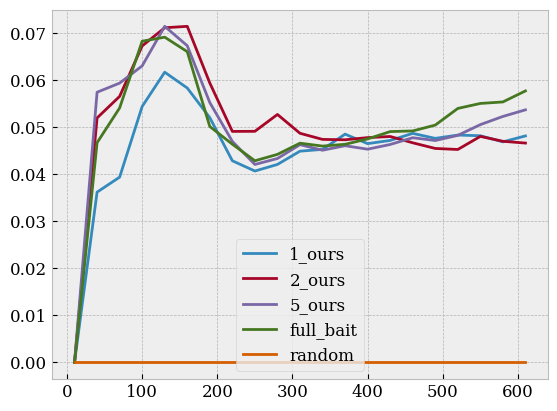

In [10]:
axis = np.mean(num_samples['random'], 0)
lc_random = np.mean(learning_curves['random'], 0)

for al_strat in al_strats:
    lcs = learning_curves[al_strat]
    lcs = [lc for lc in lcs if len(lc) > 20 ]
    
    lc = np.mean(lcs, axis=0)
    std = np.std(lcs, axis=0)
    axis = np.mean(num_samples[al_strat], axis=0)
    print(al_strat, np.mean(lc))

    plt.plot(axis, lc - lc_random, label=al_strat)
    # plt.fill_between(axis, lc - std, lc + std, alpha=.3)

plt.legend()
plt.show()

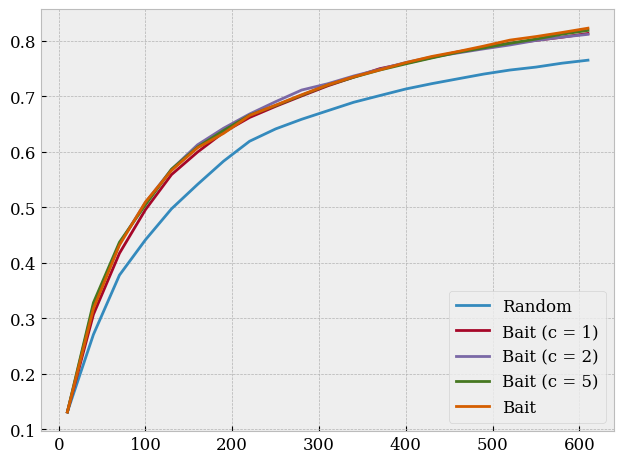

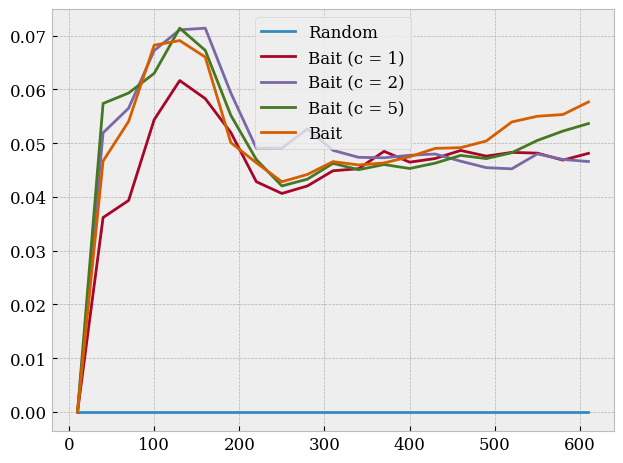

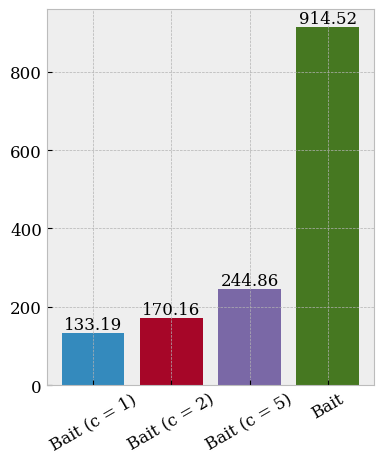

In [11]:
axis = np.mean(num_samples['random'], 0)
lc_random = np.mean(learning_curves['random'], 0)
    
plt.plot(axis, np.mean(learning_curves['random']  , axis=0), label='Random')
plt.plot(axis, np.mean(learning_curves['1_ours'] , axis=0), label='Bait (c = 1)')
plt.plot(axis, np.mean(learning_curves['2_ours'] , axis=0), label='Bait (c = 2)')
plt.plot(axis, np.mean(learning_curves['5_ours'], axis=0), label='Bait (c = 5)')
plt.plot(axis, np.mean(learning_curves['full_bait'], axis=0), label='Bait')

plt.tight_layout()
plt.legend()
plt.savefig('ablation_expectation_topc_lc.pdf')
plt.show()

axis = np.mean(num_samples['random'], 0)
lc_random = np.mean(learning_curves['random'], 0)
    
plt.plot(axis, np.mean(learning_curves['random'] -  lc , axis=0), label='Random')
plt.plot(axis, np.mean(learning_curves['1_ours'] - lc, axis=0), label='Bait (c = 1)')
plt.plot(axis, np.mean(learning_curves['2_ours'] - lc, axis=0), label='Bait (c = 2)')
plt.plot(axis, np.mean(learning_curves['5_ours'] - lc, axis=0), label='Bait (c = 5)')
plt.plot(axis, np.mean(learning_curves['full_bait'] - lc, axis=0), label='Bait')

plt.tight_layout()
plt.legend()
plt.savefig('ablation_expectation_topc_diff.pdf')
plt.show()

# plt.bar('Random', np.mean(query_times['random']))
plt.figure(figsize=(4, 4.8))
bars = []
bars.append(plt.bar('Bait (c = 1)', np.mean(query_times['1_ours'])))
bars.append(plt.bar('Bait (c = 2)', np.mean(query_times['2_ours'])))
bars.append(plt.bar('Bait (c = 5)', np.mean(query_times['5_ours'])))
bars.append(plt.bar('Bait', np.mean(query_times['full_bait'])))

for bar in bars:
    for rect in bar:
        x = rect.get_x() + rect.get_width() / 2
        height = rect.get_height()
        plt.text(x, height, f'{height:.2f}', ha='center', va='bottom')

plt.xticks(rotation=30)
plt.tight_layout()
plt.savefig('ablation_expectation_topc_time.pdf')
plt.show()

In [12]:
random_diff_auc = np.mean(learning_curves['random'], axis=0).mean()
data = [
    [np.mean(learning_curves[k], axis=0).mean()*100 for k in learning_curves],
    [(np.mean(learning_curves[k], axis=0).mean() - random_diff_auc)*100 for k in learning_curves],
    [np.mean(query_times[k]) for k in query_times],
]
df = pd.DataFrame(data, columns=learning_curves.keys(), index=['AUC', 'AUC (Performance Differences)', 'Acq Time'])
df = df[['random', '1_ours', '2_ours', '5_ours', 'full_bait']]
print(df.to_latex(float_format="%.2f"))

\begin{tabular}{lrrrrr}
\toprule
 & random & 1_ours & 2_ours & 5_ours & full_bait \\
\midrule
AUC & 60.72 & 65.23 & 65.70 & 65.65 & 65.70 \\
AUC (Performance Differences) & 0.00 & 4.51 & 4.98 & 4.92 & 4.97 \\
Acq Time & 0.00 & 133.19 & 170.16 & 244.86 & 914.52 \\
\bottomrule
\end{tabular}



## Gradient Likelihood

In [7]:
import mlflow
import numpy as np
import pylab as plt
import pandas as pd

# client = mlflow.tracking.MlflowClient(tracking_uri='sqlite:////home/dhuseljic/mlflow/bait/cifar10_ablation_likelihood.db')
client = mlflow.tracking.MlflowClient(tracking_uri='sqlite:////home/dhuseljic/mlflow/bait/letter_ablation_likelihood.db')
experiment_id = client.get_experiment_by_name('Active Learning').experiment_id

# Food-101
# client = mlflow.tracking.MlflowClient(tracking_uri='file:///home/dhuseljic/mlflow/ssal/al/food101')
# experiment_id = '270441571896962032'
runs = client.search_runs(experiment_ids=experiment_id)
print('Found {} experiments'.format(len(runs)))

Found 40 experiments


In [2]:
runs = []
init_query_list = [
    # "parameter.model.name = 'laplace_mlp'",
    "parameter.dino_model_name = 'dinov2_vits14'",
]
query_list = init_query_list + ["parameter.al.strategy = 'random'"]
query = ' and '.join(query_list)
runs.extend(client.search_runs(experiment_ids=experiment_id, filter_string=query))

query_list = init_query_list + ["parameter.al.strategy = 'typiclust'"]
query = ' and '.join(query_list)
runs.extend(client.search_runs(experiment_ids=experiment_id, filter_string=query))

query_list = init_query_list + ["parameter.al.strategy = 'bait'"]
query_list += ["parameter.al.bait.fisher_approximation = 'full'"] 
query_list += ["parameter.al.bait.expectation_topk = 'None'"] 
query_list += ["parameter.al.bait.num_grad_samples = 'None'"] 
query_list += ["parameter.al.bait.grad_likelihood = 'cross_entropy'"] 
query = ' and '.join(query_list)
runs_ = client.search_runs(experiment_ids=experiment_id, filter_string=query)
for r in runs_:
    r.data.params['al.strategy'] = 'full_' + r.data.params['al.strategy']
runs.extend(runs_)

query_list = init_query_list + ["parameter.al.strategy = 'bait'"]
query_list += ["parameter.al.bait.fisher_approximation = 'diag'"] 
query_list += ["parameter.al.bait.expectation_topk = 'None'"] 
query_list += ["parameter.al.bait.num_grad_samples = 'None'"] 
query_list += ["parameter.al.bait.grad_likelihood = 'cross_entropy'"] 
query = ' and '.join(query_list)
runs_ = client.search_runs(experiment_ids=experiment_id, filter_string=query)
for r in runs_:
    r.data.params['al.strategy'] = f'{r.data.params["al.bait.fisher_approximation"]}'
runs.extend(runs_)


query_list = init_query_list + ["parameter.al.strategy = 'bait'"]
query_list += ["parameter.al.bait.fisher_approximation = 'full'"] 
query_list += ["parameter.al.bait.expectation_topk = 'None'"] 
query_list += ["parameter.al.bait.num_grad_samples = 'None'"] 
query_list += ["parameter.al.bait.grad_likelihood = 'binary_cross_entropy'"] 
query = ' and '.join(query_list)
runs_ = client.search_runs(experiment_ids=experiment_id, filter_string=query)
for r in runs_:
    r.data.params['al.strategy'] = f'{r.data.params["al.bait.grad_likelihood"]}'
runs.extend(runs_)

# query_list = init_query_list + ["parameter.al.strategy = 'bait'"]
# query_list += ["parameter.al.bait.fisher_approximation = 'full'"] 
# query_list += ["parameter.al.bait.expectation_topk = '1'"] 
# query_list += ["parameter.al.bait.num_grad_samples = 'None'"] 
# query_list += ["parameter.al.bait.grad_likelihood = 'cross_entropy'"] 
# query = ' and '.join(query_list)
# runs_ = client.search_runs(experiment_ids=experiment_id, filter_string=query)
# for r in runs_:
#     r.data.params['al.strategy'] = f'{r.data.params["al.bait.expectation_topk"]}' + r.data.params['al.strategy']
# runs.extend(runs_)

print('Found {} experiments'.format(len(runs)))

Found 40 experiments


In [3]:
al_strats = np.unique([run.data.params['al.strategy'] for run in runs])

learning_curves = {k: [] for k in al_strats}
query_times = {k: [] for k in al_strats}
num_samples = {k: [] for k in al_strats}

for run in runs:
    al_strat = run.data.params['al.strategy']
    # if "al.update_every" in run.data.params: continue
    acc_history = client.get_metric_history(run.info.run_id, 'accuracy')
    learning_curves[al_strat].append([metric.value for metric in acc_history])

    qtime_history = client.get_metric_history(run.info.run_id, 'query_time')
    query_times[al_strat].append([metric.value for metric in qtime_history][1:])

    num_init = int(run.data.params['al.num_init_samples'])
    num_acq = int(run.data.params['al.num_acq'])
    acq_size = int(run.data.params['al.acq_size'])
    num_samples[al_strat].append(range(num_init, num_init+num_acq*acq_size+1, acq_size))

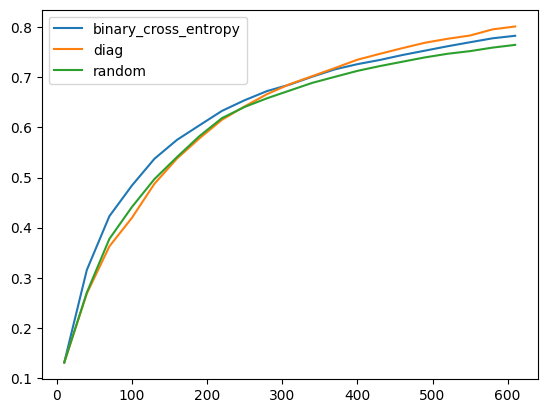

In [4]:
for al_strat in al_strats:
    lcs = learning_curves[al_strat]
    lcs = [lc for lc in lcs if len(lc) > 20]
    # print([len(lc) for lc in lcs if len(lc)< ])

    
    lc = np.mean(lcs, axis=0)
    std = np.std(lcs, axis=0)
    axis = np.mean(num_samples[al_strat], axis=0)
    plt.plot(axis, lc, label=al_strat)
    # plt.fill_between(axis, lc - std, lc + std, alpha=.3)

plt.legend()
plt.show()

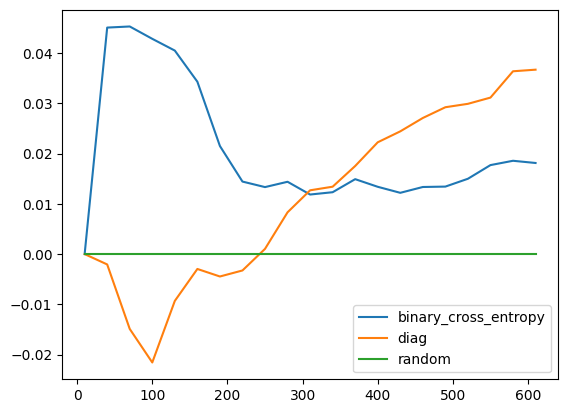

In [5]:
axis = np.mean(num_samples['random'], 0)
lc_random = np.mean(learning_curves['random'], 0)
lcs_random = learning_curves['random']

for al_strat in al_strats:
    lcs = learning_curves[al_strat]
    lcs = [lc for lc in lcs if len(lc) > 20 ]
    
    lc = np.mean(lcs, axis=0)
    std = np.std(lcs, axis=0)
    axis = np.mean(num_samples[al_strat], axis=0)

    plt.plot(axis, lc - lc_random, label=al_strat)

plt.legend()
plt.show()

KeyError: 'full_bait'

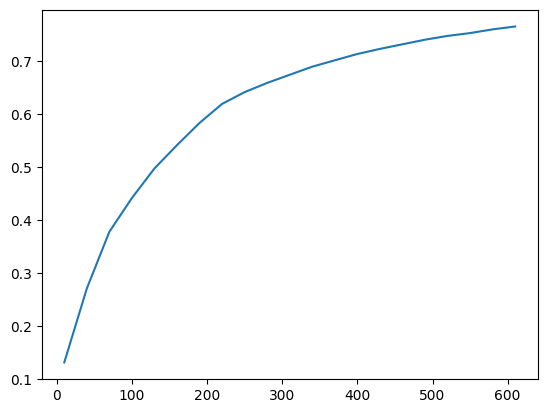

In [6]:
axis = np.mean(num_samples['random'], 0)
lc_random = np.mean(learning_curves['random'], 0)
    
plt.plot(axis, np.mean(learning_curves['random']  , axis=0), label='Random')
plt.plot(axis, np.mean(learning_curves['full_bait'] , axis=0), label='Bait')
plt.plot(axis, np.mean(learning_curves['diag'] , axis=0), label='Diag Bait')
plt.plot(axis, np.mean(learning_curves['binary_cross_entropy'] , axis=0), label='Binary CE')

plt.tight_layout()
plt.legend()
plt.savefig('ablation_likelihood_lc.pdf')
plt.show()

axis = np.mean(num_samples['random'], 0)
lc_random = np.mean(learning_curves['random'], 0)
    
plt.plot(axis, np.mean(learning_curves['random'] -  lc_random , axis=0), label='Random')
plt.plot(axis, np.mean(learning_curves['full_bait'] - lc_random, axis=0), label='Bait')
plt.plot(axis, np.mean(learning_curves['diag'] - lc_random, axis=0), label='Diag Bait')
plt.plot(axis, np.mean(learning_curves['binary_cross_entropy'] - lc_random, axis=0), label='Binary CE')

plt.tight_layout()
plt.legend()
plt.savefig('ablation_likelihood_diff.pdf')
plt.show()

# plt.bar('Random', np.mean(query_times['random']))
plt.figure(figsize=(4, 4.8))
bars = []
bars.append(plt.bar('Binary CE', np.mean(query_times['binary_cross_entropy'])))
bars.append(plt.bar('Diag', np.mean(query_times['diag'])))
bars.append(plt.bar('Bait', np.mean(query_times['full_bait'])))
# bars.append(plt.bar('Bait', np.mean(query_times['full_bait'])))

for bar in bars:
    for rect in bar:
        x = rect.get_x() + rect.get_width() / 2
        height = rect.get_height()
        plt.text(x, height, f'{height:.2f}', ha='center', va='bottom')

plt.xticks(rotation=30)
plt.tight_layout()
plt.savefig('ablation_expectation_topc_time.pdf')
plt.show()

In [6]:
random_diff_auc = np.mean(learning_curves['random'], axis=0).mean()
data = [
    [np.mean(learning_curves[k], axis=0).mean()*100 for k in learning_curves],
    [(np.mean(learning_curves[k], axis=0).mean() - random_diff_auc)*100 for k in learning_curves],
    [np.mean(query_times[k]) for k in query_times],
]
df = pd.DataFrame(data, columns=learning_curves.keys(), index=['AUC', 'AUC (Performance Differences)', 'Acq Time'])
df = df[['random', 'diag', 'binary_cross_entropy', 'full_bait']]
print(df.to_latex(float_format="%.2f"))

KeyError: "['diag', 'binary_cross_entropy', 'full_bait'] not in index"

## Benchmark

In [10]:
import mlflow
import numpy as np
import pylab as plt
import pandas as pd

dataset = 'cifar100'
client = mlflow.tracking.MlflowClient(tracking_uri=f'sqlite:////home/dhuseljic/mlflow/bait/{dataset}_benchmark.db')
experiment_id = client.get_experiment_by_name('Active Learning').experiment_id

runs = client.search_runs(experiment_ids=experiment_id)
print('Found {} experiments'.format(len(runs)))

Found 30 experiments


In [23]:
runs = []
init_query_list = [
    # "parameter.model.name = 'laplace_mlp'",
    "parameter.dino_model_name = 'dinov2_vits14'",
]
query_list = init_query_list + ["parameter.al.strategy = 'random'"]
query = ' and '.join(query_list)
runs.extend(client.search_runs(experiment_ids=experiment_id, filter_string=query))

query_list = init_query_list + ["parameter.al.strategy = 'typiclust'"]
query = ' and '.join(query_list)
runs.extend(client.search_runs(experiment_ids=experiment_id, filter_string=query))

query_list = init_query_list + ["parameter.al.strategy = 'bait'"]
query_list += ["parameter.al.bait.fisher_approximation = 'full'"] 
query_list += ["parameter.al.bait.expectation_topk = 'None'"] 
query_list += ["parameter.al.bait.grad_likelihood = 'cross_entropy'"] 
query = ' and '.join(query_list)
runs_ = client.search_runs(experiment_ids=experiment_id, filter_string=query)
runs.extend(runs_)

query_list = init_query_list + ["parameter.al.strategy = 'bait'"]
query_list += ["parameter.al.bait.fisher_approximation = 'full'"] 
query_list += ["parameter.al.bait.expectation_topk = 'None'"] 
query_list += ["parameter.al.bait.grad_likelihood = 'binary_cross_entropy'"] 
query = ' and '.join(query_list)
runs_ = client.search_runs(experiment_ids=experiment_id, filter_string=query)
for r in runs_:
    r.data.params['al.strategy'] = 'bce_' + r.data.params['al.strategy']
runs.extend(runs_)

print('Found {} experiments'.format(len(runs)))

Found 30 experiments


In [24]:
al_strats = np.unique([run.data.params['al.strategy'] for run in runs])

learning_curves = {k: [] for k in al_strats}
query_times = {k: [] for k in al_strats}
num_samples = {k: [] for k in al_strats}

for run in runs:
    al_strat = run.data.params['al.strategy']
    # if "al.update_every" in run.data.params: continue
    acc_history = client.get_metric_history(run.info.run_id, 'accuracy')
    learning_curves[al_strat].append([metric.value for metric in acc_history])

    qtime_history = client.get_metric_history(run.info.run_id, 'query_time')
    query_times[al_strat].append([metric.value for metric in qtime_history][1:])

    num_init = int(run.data.params['al.num_init_samples'])
    num_acq = int(run.data.params['al.num_acq'])
    acq_size = int(run.data.params['al.acq_size'])
    num_samples[al_strat].append(range(num_init, num_init+num_acq*acq_size+1, acq_size))

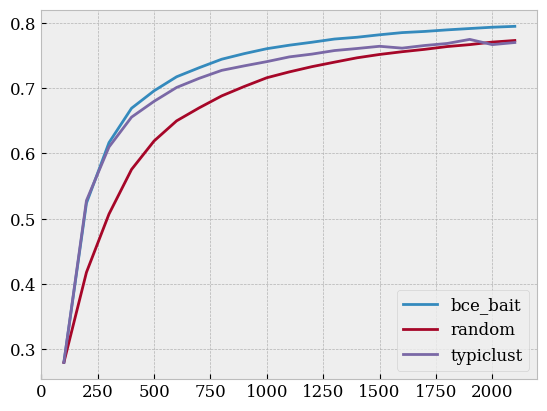

In [27]:
for al_strat in al_strats:
    lcs = learning_curves[al_strat]
    lcs = [lc for lc in lcs if len(lc) > 20]
    # print([len(lc) for lc in lcs if len(lc)< ])

    
    lc = np.mean(lcs, axis=0)
    std = np.std(lcs, axis=0)
    axis = np.mean(num_samples[al_strat], axis=0)
    plt.plot(axis, lc, label=al_strat)
    # plt.fill_between(axis, lc - std, lc + std, alpha=.3)

plt.legend()
plt.show()

## Graphical Abstract

KeyError: 'badge'

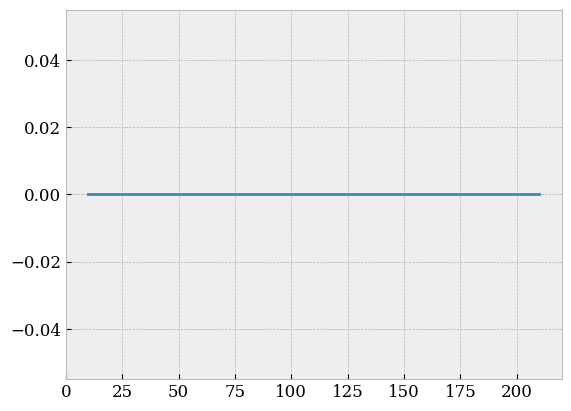

In [28]:
mapping = {
    'random': 'Random', 
    'typiclust':'Typiclust', 
    'badge':'Badge', 
    'original_bait':'Bait', 
    'bait_binary_cross_entropy_None': 'Bait Approximation'
}

axis = np.mean(num_samples['random'], 0)
lc_random = np.mean(learning_curves['random'], 0)
    
plt.plot(axis, np.mean(learning_curves['random'], axis=0) - lc_random, label='Random')
plt.plot(axis, np.mean(learning_curves['badge'], axis=0) - lc_random, label='Badge')
plt.plot(axis, np.mean(learning_curves['typiclust'], axis=0) - lc_random, label='Typiclust')
plt.plot(axis, np.mean(learning_curves['original_bait'], axis=0) - lc_random, label='Bait')
plt.legend(loc=1)

plt.tight_layout()
plt.savefig('graphical_abstract_a.pdf')
plt.show()

In [29]:
al_strats = np.unique([run.data.params['al.strategy'] for run in runs])

query_times = {k: [] for k in al_strats}

for run in runs:
    al_strat = run.data.params['al.strategy']
    qtime_history = client.get_metric_history(run.info.run_id, 'query_time')
    query_times[al_strat].append([metric.value for metric in qtime_history][1:])

KeyError: 'badge'

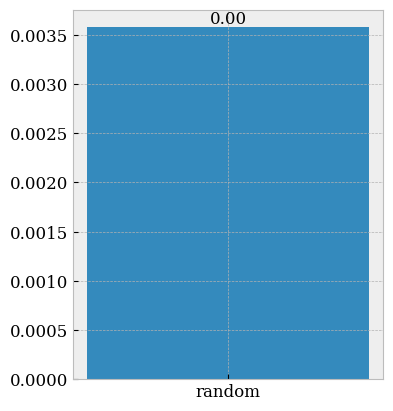

In [30]:
from datetime import timedelta

plt.figure(figsize=(4, 4.8))
for strat in ['random', 'badge', 'typiclust', 'original_bait']:
    bar = plt.bar(strat, np.mean(query_times[strat]))

    for rect in bar:
        x = rect.get_x() + rect.get_width() / 2
        height = rect.get_height()
        plt.text(x, height, f'{height:.2f}', ha='center', va='bottom')


plt.gca().set_yscale('log')
plt.tight_layout()
plt.gca().xaxis.set_visible(False)

# plt.ylabel('Acquisition Time')
plt.savefig('graphical_abstract_b.pdf')
plt.show()